# Full Imagenet

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['OMP_NUM_THREADS']='1'

In [ ]:
import pickle,gzip

from glob import glob
from torcheval.metrics import MulticlassAccuracy

from miniai.imports import *

In [ ]:
from fastprogress import progress_bar
from diffusers import AutoencoderKL

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'


In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
path_data = Path('data')/'ILSVRC'
path = path_data/'Data'/'CLS-LOC'

dest = path_data/'latents'
dest.mkdir(exist_ok=True)

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

In [ ]:
class ImagesDS:
    def __init__(self, path, spec):
        cache = path/'files.zpkl'
        if cache.exists():
            with gzip.open(cache) as f: self.files = pickle.load(f)
        else:
            self.files = glob(str(path/spec), recursive=True)
            with gzip.open(cache, 'wb', compresslevel=1) as f: pickle.dump(self.files, f)

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        f = self.files[i]
        im = read_image(f, mode=ImageReadMode.RGB)/255
        im = TF.resize(TF.center_crop(im, min(im.shape[1:])), 256)
        return im,f

In [ ]:
ds = ImagesDS(path, '**/*.JPEG')
dl = DataLoader(ds, batch_size=64, num_workers=fc.defaults.cpus)

In [ ]:
xb,yb = next(iter(dl))
xe = vae.encode(xb.cuda())
xs = xe.latent_dist.mean
xs.shape

torch.Size([64, 4, 32, 32])

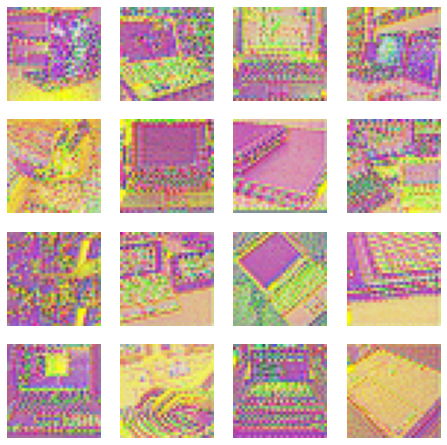

In [ ]:
show_images(((xs[:16,:3])/4).sigmoid(), imsize=2)

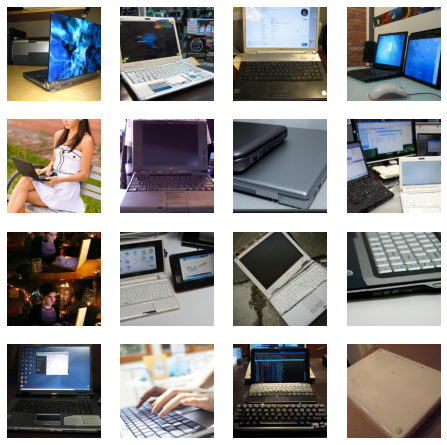

In [ ]:
xd = to_cpu(vae.decode(xs))
show_images(xd['sample'][:16].clamp(0,1), imsize=2)

In [ ]:
if not dest.exists():
    dest.mkdir()
    for xb,yb in progress_bar(dl):
        eb = to_cpu(vae.encode(xb.cuda()).latent_dist.mean).numpy()
        for ebi,ybi in zip(eb,yb):
            ybi = dest/Path(ybi).relative_to(path).with_suffix('')
            (ybi.parent).mkdir(parents=True, exist_ok=True)
            np.save(ybi, ebi)

In [ ]:
class NumpyDS(ImagesDS):
    def __getitem__(self, i):
        f = self.files[i]
        im = np.load(f)
        return im,f

In [ ]:
bs = 128

In [ ]:
tds = NumpyDS(dest/'train', '**/*.npy')
vds = NumpyDS(dest/'val', '**/*.npy')

In [ ]:
tdl = DataLoader(tds, batch_size=bs, num_workers=0)
xb,yb = next(iter(tdl))
xb.mean((0,2,3)),xb.std((0,2,3))

(tensor([ 5.23983,  2.59586,  0.45112, -2.28669]),
 tensor([3.94172, 4.42124, 3.24268, 3.09760]))

In [ ]:
xmean,xstd = (tensor([ 5.37007,  2.65468,  0.44876, -2.39154]),
 tensor([3.99512, 4.44317, 3.21629, 3.10339]))

In [ ]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [ ]:
id2str = (path_data/'imagenet_lsvrc_2015_synsets.txt').read_text().splitlines()
str2id = {v:k for k,v in enumerate(id2str)}

In [ ]:
aug_tfms = nn.Sequential(T.Pad(2), T.RandomCrop(32), RandErase())
norm_tfm = T.Normalize(xmean, xstd)

In [ ]:
def tfmx(x, aug=False):
    x = norm_tfm(tensor(x))
    if aug: x = aug_tfms(x[None])[0]
    return x

def tfmy(y): return tensor(str2id[Path(y).parent.name])

tfm_tds = TfmDS(tds, partial(tfmx, aug=True), tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [ ]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None])

In [ ]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [ ]:
all_synsets = [o.split('\t') for o in (path_data/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

In [ ]:
xb,yb = next(iter(dls.train))
titles = [synsets[id2str[o]] for o in yb]
xb.mean(),xb.std()

(tensor(-0.02974), tensor(0.97078))

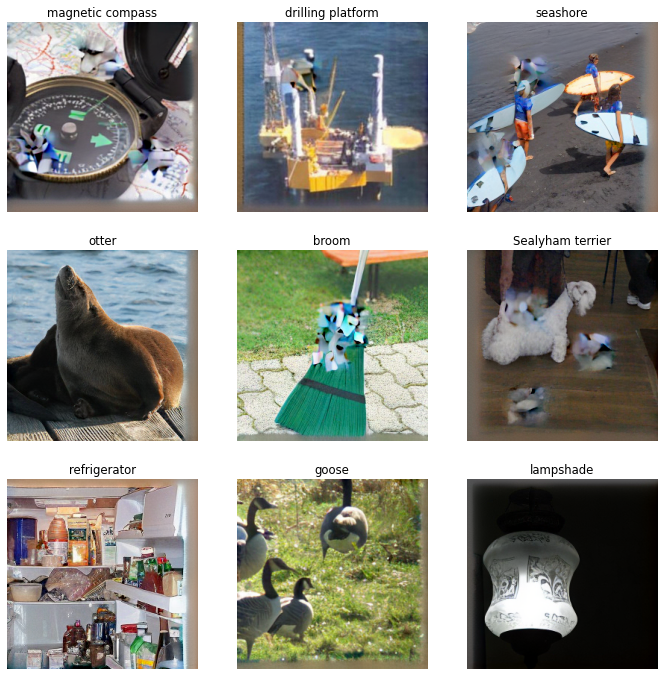

In [ ]:
xd = to_cpu(vae.decode(denorm(xb[:9]).cuda()))
show_images(xd['sample'].clamp(0,1), imsize=4, titles=titles[:9])

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

opt_func = partial(optim.AdamW, eps=1e-5)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

In [ ]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1     , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

def get_dropmodel(nfs, nbks, act=act_gr, norm=nn.BatchNorm2d, drop=0.2):
    layers = [nn.Conv2d(4, nfs[0], 5, padding=2)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 1000, bias=False), nn.BatchNorm1d(1000)]
    return nn.Sequential(*layers).apply(iw)

In [ ]:
epochs = 40
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(nbks=(1,2,4,3), nfs=(32, 64, 128, 512, 1024), drop=0.1)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.134,4.711,0,train
0.253,3.666,0,eval
0.281,3.468,1,train
0.339,3.127,1,eval
0.348,3.022,2,train
0.354,3.063,2,eval
0.385,2.799,3,train
0.377,2.926,3,eval
0.406,2.675,4,train
0.400,2.807,4,eval


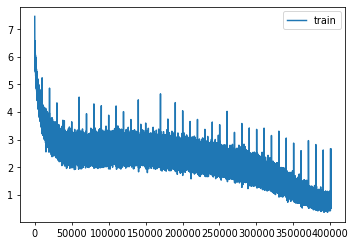

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/imgnet-latents')

### fin -